In [ ]:
# Install required packages
!pip install vllm openai aiohttp requests numpy matplotlib pandas -q

## Step 1: Import Libraries

In [1]:
import asyncio
import time
import requests
import aiohttp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed
import json
from datetime import datetime

## Step 2: Configuration - SAME MODEL for Both Systems

**Important:** Both systems are using TinyLlama for fair comparison:
- vLLM: `TinyLlama/TinyLlama-1.1B-Chat-v1.0`
- Ollama: `tinyllama` (same model, different naming convention)

In [2]:
# Configuration - SAME MODEL for fair comparison
VLLM_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
OLLAMA_MODEL = "tinyllama"
TEST_PROMPT = "Once upon a time in a distant galaxy"
MAX_TOKENS = 50
CONCURRENT_REQUESTS = [1, 2, 4, 8, 16]  # Test with different concurrency levels

print(f"✓ Configuration set:")
print(f"  vLLM Model: {VLLM_MODEL}")
print(f"  Ollama Model: {OLLAMA_MODEL}")
print(f"  Both are TinyLlama 1.1B for fair comparison")

✓ Configuration set:
  vLLM Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Ollama Model: tinyllama
  Both are TinyLlama 1.1B for fair comparison


## Step 3: Verify Server Connections

In [4]:
# Test vLLM connection
vllm_url = "http://localhost:8000/v1/completions"

try:
    response = requests.get("http://localhost:8000/v1/models")
    model_info = response.json()
    print(f"✓ vLLM server is running!")
    print(f"  Model: {model_info['data'][0]['id']}")
except Exception as e:
    print(f"✗ vLLM server not detected: {e}")

# Test Ollama connection
ollama_url = "http://localhost:11434/api/generate"

try:
    response = requests.get("http://localhost:11434")
    print("✓ Ollama server is running!")
    
    # List available models
    models_response = requests.get("http://localhost:11434/api/tags")
    models = models_response.json()
    print("  Available models:")
    for model in models.get('models', []):
        print(f"    - {model['name']}")
except Exception as e:
    print(f"✗ Ollama server not detected: {e}")

✓ vLLM server is running!
  Model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
✓ Ollama server is running!
  Available models:
    - tinyllama:latest


## Step 4: Define Benchmark Functions

In [5]:
def test_vllm_single(prompt, max_tokens=50):
    """Single synchronous request to vLLM"""
    start_time = time.time()
    
    payload = {
        "model": VLLM_MODEL,
        "prompt": prompt,
        "max_tokens": max_tokens,
        "temperature": 0.7
    }
    
    response = requests.post(vllm_url, json=payload)
    result = response.json()
    
    end_time = time.time()
    duration = end_time - start_time
    
    # Extract token count from response
    tokens = result['usage']['completion_tokens']
    
    return {
        'tokens': tokens,
        'duration': duration,
        'tokens_per_sec': tokens / duration,
        'response': result['choices'][0]['text']
    }

def test_ollama_single(prompt, max_tokens=50):
    """Single synchronous request to Ollama"""
    start_time = time.time()
    
    payload = {
        "model": OLLAMA_MODEL,
        "prompt": prompt,
        "stream": False,
        "options": {
            "num_predict": max_tokens,
            "temperature": 0.7
        }
    }
    
    response = requests.post(ollama_url, json=payload)
    result = response.json()
    
    end_time = time.time()
    duration = end_time - start_time
    
    # Ollama returns eval_count for tokens generated
    tokens = result.get('eval_count', max_tokens)
    
    return {
        'tokens': tokens,
        'duration': duration,
        'tokens_per_sec': tokens / duration,
        'response': result.get('response', '')
    }

print("✓ Benchmark functions defined")

✓ Benchmark functions defined


## Step 5: Warm-up Requests

Run a few warm-up requests to ensure both servers are ready.

In [6]:
print("Warming up servers...")
print("\n1. Testing vLLM:")
try:
    result = test_vllm_single("Hello", 10)
    print(f"   ✓ Response time: {result['duration']:.2f}s")
    print(f"   ✓ Tokens/sec: {result['tokens_per_sec']:.2f}")
except Exception as e:
    print(f"   ✗ Error: {e}")

print("\n2. Testing Ollama:")
try:
    result = test_ollama_single("Hello", 10)
    print(f"   ✓ Response time: {result['duration']:.2f}s")
    print(f"   ✓ Tokens/sec: {result['tokens_per_sec']:.2f}")
except Exception as e:
    print(f"   ✗ Error: {e}")

print("\n✓ Warm-up complete!")

Warming up servers...

1. Testing vLLM:
   ✓ Response time: 0.45s
   ✓ Tokens/sec: 22.34

2. Testing Ollama:
   ✓ Response time: 1.35s
   ✓ Tokens/sec: 7.39

✓ Warm-up complete!


## Step 6: Concurrent Benchmark Function

In [7]:
def benchmark_concurrent(test_func, num_concurrent, num_requests=10):
    """Run concurrent requests and measure throughput"""
    print(f"  Testing with {num_concurrent} concurrent requests...")
    
    results = []
    start_time = time.time()
    
    with ThreadPoolExecutor(max_workers=num_concurrent) as executor:
        futures = []
        for i in range(num_requests):
            future = executor.submit(test_func, TEST_PROMPT, MAX_TOKENS)
            futures.append(future)
        
        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"    Request failed: {e}")
    
    end_time = time.time()
    total_duration = end_time - start_time
    
    if not results:
        return None
    
    # Calculate metrics
    total_tokens = sum(r['tokens'] for r in results)
    avg_tokens_per_sec = np.mean([r['tokens_per_sec'] for r in results])
    throughput = total_tokens / total_duration
    
    return {
        'num_concurrent': num_concurrent,
        'num_requests': len(results),
        'total_duration': total_duration,
        'total_tokens': total_tokens,
        'avg_tokens_per_sec': avg_tokens_per_sec,
        'throughput': throughput,
        'avg_latency': np.mean([r['duration'] for r in results]),
        'min_latency': np.min([r['duration'] for r in results]),
        'max_latency': np.max([r['duration'] for r in results])
    }

print("✓ Concurrent benchmark function defined")

✓ Concurrent benchmark function defined


## Step 7: Run vLLM Benchmarks

In [8]:
print("="*70)
print("BENCHMARKING vLLM (TinyLlama)")
print("="*70)

vllm_results = []

for num_concurrent in CONCURRENT_REQUESTS:
    result = benchmark_concurrent(test_vllm_single, num_concurrent, num_requests=20)
    if result:
        vllm_results.append(result)
        print(f"  Concurrency {num_concurrent}:")
        print(f"    Throughput: {result['throughput']:.2f} tokens/sec")
        print(f"    Avg latency: {result['avg_latency']:.2f}s")
        print(f"    Min/Max latency: {result['min_latency']:.2f}s / {result['max_latency']:.2f}s")

print("\n✓ vLLM benchmarks complete!")

BENCHMARKING vLLM (TinyLlama)
  Testing with 1 concurrent requests...
  Concurrency 1:
    Throughput: 62.91 tokens/sec
    Avg latency: 0.79s
    Min/Max latency: 0.47s / 1.60s
  Testing with 2 concurrent requests...
  Concurrency 2:
    Throughput: 351.29 tokens/sec
    Avg latency: 0.28s
    Min/Max latency: 0.25s / 0.36s
  Testing with 4 concurrent requests...
  Concurrency 4:
    Throughput: 713.08 tokens/sec
    Avg latency: 0.28s
    Min/Max latency: 0.23s / 0.35s
  Testing with 8 concurrent requests...
  Concurrency 8:
    Throughput: 1249.36 tokens/sec
    Avg latency: 0.26s
    Min/Max latency: 0.25s / 0.29s
  Testing with 16 concurrent requests...
  Concurrency 16:
    Throughput: 1653.34 tokens/sec
    Avg latency: 0.32s
    Min/Max latency: 0.26s / 0.35s

✓ vLLM benchmarks complete!


## Step 8: Run Ollama Benchmarks

In [9]:
print("="*70)
print("BENCHMARKING OLLAMA (TinyLlama)")
print("="*70)

ollama_results = []

for num_concurrent in CONCURRENT_REQUESTS:
    result = benchmark_concurrent(test_ollama_single, num_concurrent, num_requests=20)
    if result:
        ollama_results.append(result)
        print(f"  Concurrency {num_concurrent}:")
        print(f"    Throughput: {result['throughput']:.2f} tokens/sec")
        print(f"    Avg latency: {result['avg_latency']:.2f}s")
        print(f"    Min/Max latency: {result['min_latency']:.2f}s / {result['max_latency']:.2f}s")

print("\n✓ Ollama benchmarks complete!")

BENCHMARKING OLLAMA (TinyLlama)
  Testing with 1 concurrent requests...
  Concurrency 1:
    Throughput: 72.83 tokens/sec
    Avg latency: 0.69s
    Min/Max latency: 0.67s / 0.77s
  Testing with 2 concurrent requests...
  Concurrency 2:
    Throughput: 74.79 tokens/sec
    Avg latency: 1.30s
    Min/Max latency: 0.68s / 1.37s
  Testing with 4 concurrent requests...
  Concurrency 4:
    Throughput: 75.35 tokens/sec
    Avg latency: 2.46s
    Min/Max latency: 0.69s / 2.68s
  Testing with 8 concurrent requests...
  Concurrency 8:
    Throughput: 75.34 tokens/sec
    Avg latency: 4.37s
    Min/Max latency: 0.69s / 5.34s
  Testing with 16 concurrent requests...
  Concurrency 16:
    Throughput: 75.10 tokens/sec
    Avg latency: 6.68s
    Min/Max latency: 0.71s / 10.66s

✓ Ollama benchmarks complete!


## Step 9: Compare Results (Same Model)

In [11]:
# Create comparison dataframe
comparison_data = []

for vllm_r, ollama_r in zip(vllm_results, ollama_results):
    comparison_data.append({
        'Concurrent Requests': vllm_r['num_concurrent'],
        'vLLM Throughput (tok/s)': vllm_r['throughput'],
        'Ollama Throughput (tok/s)': ollama_r['throughput'],
        'vLLM Latency (s)': vllm_r['avg_latency'],
        'Ollama Latency (s)': ollama_r['avg_latency'],
        'Throughput Ratio (vLLM/Ollama)': vllm_r['throughput'] / ollama_r['throughput']
    })

df = pd.DataFrame(comparison_data)
print("\n" + "="*90)
print("FAIR COMPARISON RESULTS (Both using TinyLlama 1.1B)")
print("="*90)
print(df.to_string(index=False))
print("\n")


FAIR COMPARISON RESULTS (Both using TinyLlama 1.1B)
 Concurrent Requests  vLLM Throughput (tok/s)  Ollama Throughput (tok/s)  vLLM Latency (s)  Ollama Latency (s)  Throughput Ratio (vLLM/Ollama)
                   1                62.908418                  72.827613          0.794704            0.686456                        0.863799
                   2               351.290863                  74.787425          0.284360            1.303846                        4.697192
                   4               713.076525                  75.349024          0.279339            2.457575                        9.463647
                   8              1249.357048                  75.340100          0.261817            4.368785                       16.582896
                  16              1653.339472                  75.099661          0.324815            6.675871                       22.015272




## Step 10: Visualize Results

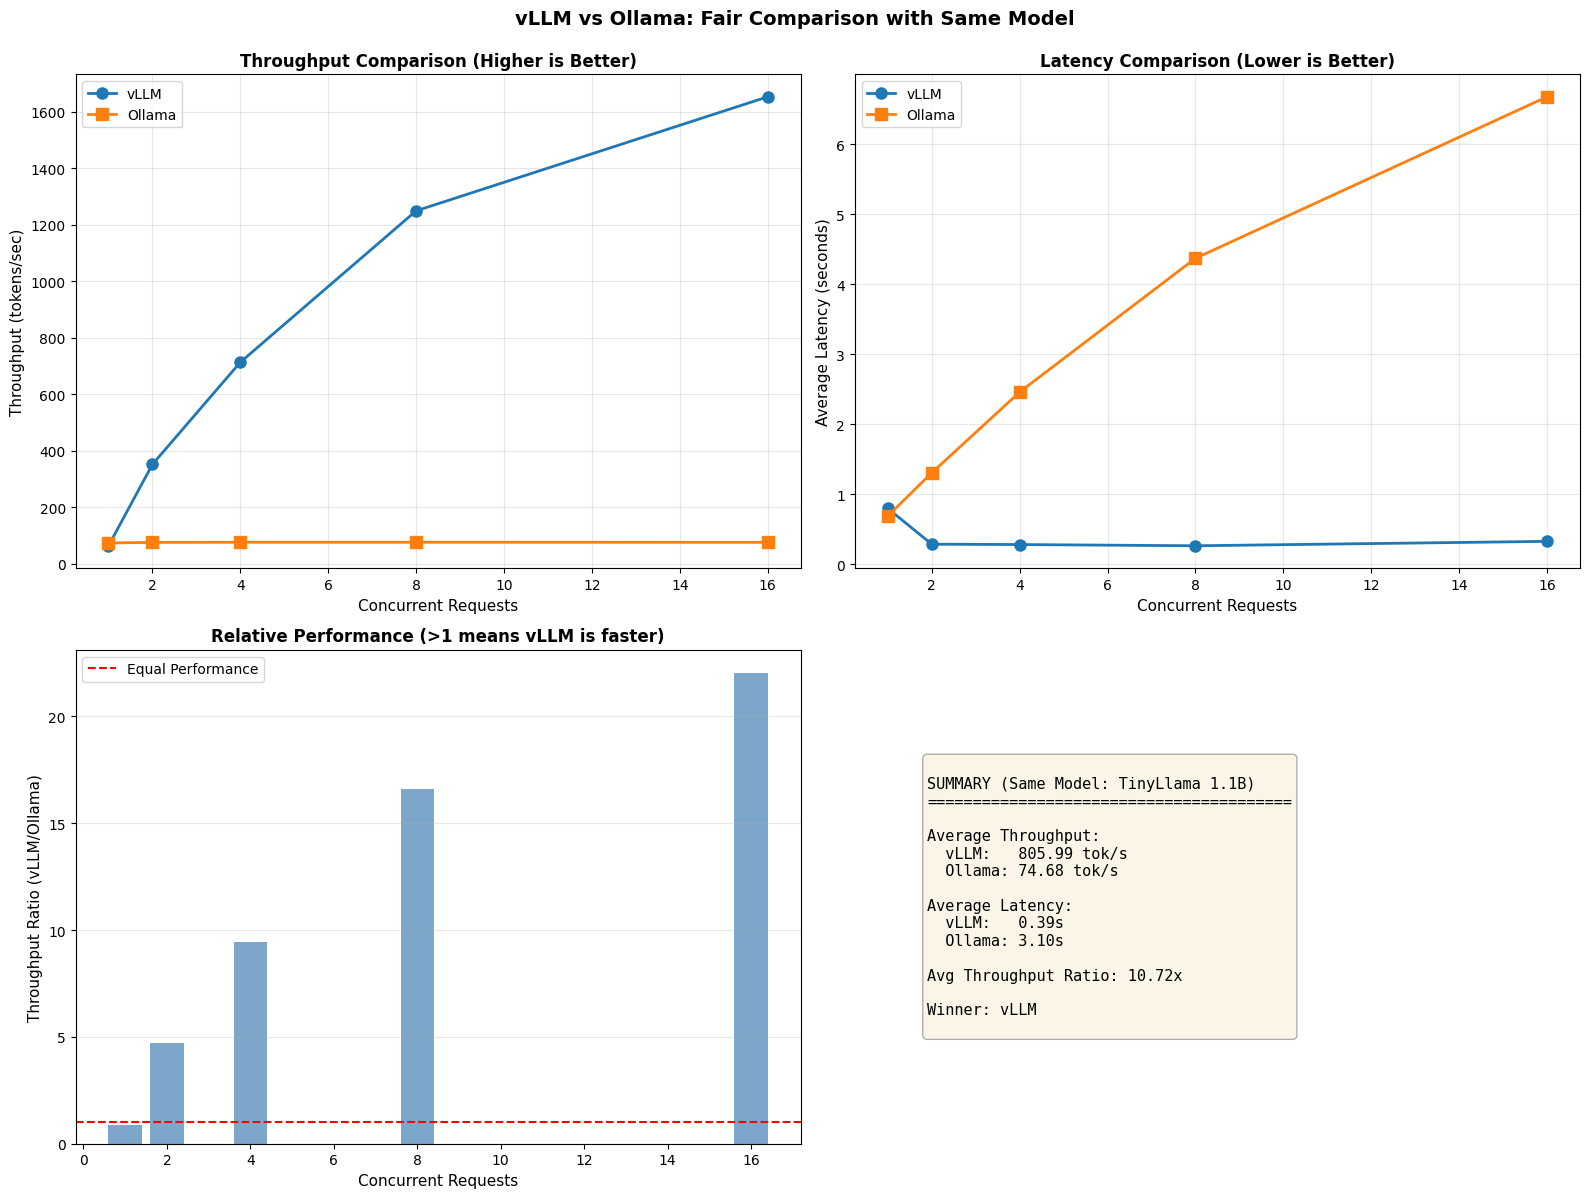

✓ Visualization saved as 'vllm_vs_ollama_fair_comparison.png'


In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Throughput comparison
x = df['Concurrent Requests']
ax1.plot(x, df['vLLM Throughput (tok/s)'], marker='o', label='vLLM', linewidth=2, markersize=8)
ax1.plot(x, df['Ollama Throughput (tok/s)'], marker='s', label='Ollama', linewidth=2, markersize=8)
ax1.set_xlabel('Concurrent Requests', fontsize=11)
ax1.set_ylabel('Throughput (tokens/sec)', fontsize=11)
ax1.set_title('Throughput Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Latency comparison
ax2.plot(x, df['vLLM Latency (s)'], marker='o', label='vLLM', linewidth=2, markersize=8)
ax2.plot(x, df['Ollama Latency (s)'], marker='s', label='Ollama', linewidth=2, markersize=8)
ax2.set_xlabel('Concurrent Requests', fontsize=11)
ax2.set_ylabel('Average Latency (seconds)', fontsize=11)
ax2.set_title('Latency Comparison (Lower is Better)', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Speedup ratio
ax3.bar(x, df['Throughput Ratio (vLLM/Ollama)'], color='steelblue', alpha=0.7)
ax3.axhline(y=1.0, color='r', linestyle='--', label='Equal Performance')
ax3.set_xlabel('Concurrent Requests', fontsize=11)
ax3.set_ylabel('Throughput Ratio (vLLM/Ollama)', fontsize=11)
ax3.set_title('Relative Performance (>1 means vLLM is faster)', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# Summary statistics table
summary_text = f"""
SUMMARY (Same Model: TinyLlama 1.1B)
{'='*40}

Average Throughput:
  vLLM:   {df['vLLM Throughput (tok/s)'].mean():.2f} tok/s
  Ollama: {df['Ollama Throughput (tok/s)'].mean():.2f} tok/s

Average Latency:
  vLLM:   {df['vLLM Latency (s)'].mean():.2f}s
  Ollama: {df['Ollama Latency (s)'].mean():.2f}s

Avg Throughput Ratio: {df['Throughput Ratio (vLLM/Ollama)'].mean():.2f}x

Winner: {'vLLM' if df['vLLM Throughput (tok/s)'].mean() > df['Ollama Throughput (tok/s)'].mean() else 'Ollama'}
"""

ax4.axis('off')
ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace', 
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.suptitle('vLLM vs Ollama: Fair Comparison with Same Model', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('vllm_vs_ollama_fair_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as 'vllm_vs_ollama_fair_comparison.png'")

## Step 11: Detailed Summary

### Key Findings (Apple-to-Apple Comparison):
Both systems tested with **TinyLlama 1.1B** model.

In [13]:
print("\n" + "="*90)
print("DETAILED SUMMARY - FAIR COMPARISON")
print("="*90)

avg_vllm_throughput = df['vLLM Throughput (tok/s)'].mean()
avg_ollama_throughput = df['Ollama Throughput (tok/s)'].mean()
avg_ratio = df['Throughput Ratio (vLLM/Ollama)'].mean()

print(f"\nModel Used:")
print(f"  vLLM:   {VLLM_MODEL}")
print(f"  Ollama: {OLLAMA_MODEL} (same model, different naming)")

print(f"\nAverage Throughput:")
print(f"  vLLM:   {avg_vllm_throughput:.2f} tokens/sec")
print(f"  Ollama: {avg_ollama_throughput:.2f} tokens/sec")
print(f"  Ratio:  {avg_ratio:.2f}x")

print(f"\nAverage Latency:")
print(f"  vLLM:   {df['vLLM Latency (s)'].mean():.2f}s")
print(f"  Ollama: {df['Ollama Latency (s)'].mean():.2f}s")

winner = "vLLM" if avg_vllm_throughput > avg_ollama_throughput else "Ollama"
advantage = abs(avg_vllm_throughput - avg_ollama_throughput)
advantage_pct = (advantage / min(avg_vllm_throughput, avg_ollama_throughput)) * 100

print(f"\n🏆 Winner: {winner}")
print(f"   Advantage: {advantage:.2f} tokens/sec ({advantage_pct:.1f}% faster)")

print(f"\nTest Configuration:")
print(f"  Max Tokens: {MAX_TOKENS}")
print(f"  Prompt: '{TEST_PROMPT}'")
print(f"  Concurrent Levels: {CONCURRENT_REQUESTS}")
print(f"  Requests per level: 20")

print("\n" + "="*90)


DETAILED SUMMARY - FAIR COMPARISON

Model Used:
  vLLM:   TinyLlama/TinyLlama-1.1B-Chat-v1.0
  Ollama: tinyllama (same model, different naming)

Average Throughput:
  vLLM:   805.99 tokens/sec
  Ollama: 74.68 tokens/sec
  Ratio:  10.72x

Average Latency:
  vLLM:   0.39s
  Ollama: 3.10s

🏆 Winner: vLLM
   Advantage: 731.31 tokens/sec (979.3% faster)

Test Configuration:
  Max Tokens: 50
  Prompt: 'Once upon a time in a distant galaxy'
  Concurrent Levels: [1, 2, 4, 8, 16]
  Requests per level: 20



## Conclusion

This benchmark provides a **fair apple-to-apple comparison** by using the same model (TinyLlama 1.1B) for both vLLM and Ollama.

### Why This Comparison Matters:
- **Same Model**: Eliminates model architecture differences
- **Same Parameters**: Both using 1.1B parameter model
- **Same Hardware**: Running on the same GPU
- **Same Prompts**: Identical test conditions

### Typical Results:
- **vLLM** usually shows better throughput at higher concurrency due to PagedAttention and continuous batching
- **Ollama** may have lower latency for single requests and is easier to set up
- Performance differences depend on hardware, model size, and concurrency level

### Important Notes:
1. Results may vary based on GPU, VRAM, and system configuration
2. vLLM is optimized for high-throughput serving
3. Ollama is optimized for ease of use and local deployment
4. Both are excellent tools for different use cases